In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv')
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv')
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv')
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')
true_train_label = train_label.copy()

In [0]:
class data_transform(object):
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:        
            temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'count', 'max', 'std']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        groupby_dict2 = defaultdict()
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                groupby_dict2[feature] = 'nunique'
            else:
                groupby_dict2[feature] = 'sum'
        else:
            output_df2 = output_df2.groupby(['acc_id', 'week']).agg(groupby_dict2).reset_index()
        
        output_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'week'])
        
        return output_df
    
    def combat_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server', 'class', 'level']] = output_df[['server', 'class', 'level']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def pledge_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server']] = output_df[['server']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'pledge_id']:
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        return output_df

# survival time

## train

### acitivity

In [0]:
transform = data_transform(train_activity)
transform.create_week()
act_train = transform.activity_transform()

### payment

In [0]:
transform = data_transform(train_payment)
transform.create_week()
pay_train = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(train_trade)
trandform.create_week()
tra_train = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(train_combat)
trandform.create_week()
com_train = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(train_pledge)
trandform.create_week()
ple_train = trandform.pledge_transform()

## test

### activity

In [0]:
transform = data_transform(test1_activity)
transform.create_week()
act_test1 = transform.activity_transform()

transform = data_transform(test2_activity)
transform.create_week()
act_test2 = transform.activity_transform()

### payment

In [0]:
transform = data_transform(test1_payment)
transform.create_week()
pay_test1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
pay_test2 = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(test1_trade)
trandform.create_week()
tra_test1 = trandform.trade_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
tra_test2 = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(test1_combat)
trandform.create_week()
com_test1 = trandform.combat_transform()

trandform = data_transform(test2_combat)
trandform.create_week()
com_test2 = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(test1_pledge)
trandform.create_week()
ple_test1 = trandform.pledge_transform()

trandform = data_transform(test2_pledge)
trandform.create_week()
ple_test2 = trandform.pledge_transform()

## model

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, kind):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data[list(set(train_data.columns) & set(test1_data.columns) & set(test2_data.columns))].drop(columns=['acc_id', 'week']).columns.tolist()
        self.kind = kind
        self.lgb_model_st = defaultdict()
        self.lgb_model_tas = defaultdict()
        self.true_index = defaultdict()
    
    
    
    
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id').dropna().reset_index(drop=True)
        for week in range(1, 5):
            self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            
    def labeling_tas(self, payment):
        self.train_data.drop(columns='survival_time', inplace=True)
        self.train_data = pd.merge(self.train_data, self.train_label, how='left', on='acc_id').dropna().reset_index(drop=True)
        self.train_data['adjust_survival_time'] = self.train_data['survival_time'] + self.train_data['week']*7
        
        def payment_transform(data):
            data['week'] = (data['day']-1)//7 + 1
            data = data.groupby(['acc_id', 'week']).sum().reset_index()
            return data
        payment = payment_transform(payment)
        
        def temp_func(data):
            if data['adjust_survival_time']>64:
                over_value = data['adjust_survival_time'] - 64
                data['adjust_survival_time'] = data['survival_time'] - over_value
            else:
                data['adjust_survival_time'] = data['survival_time']
            return data['adjust_survival_time']
        
        self.train_data['adjust_survival_time'] = self.train_data[['survival_time', 'adjust_survival_time']].apply(temp_func, axis=1)
        self.train_data['payment'] = 0
        
        for week in range(1, 4):
            self.train_data.loc[self.train_data['week']==week, 'payment'] = pd.merge(self.train_data.loc[self.train_data['week']==week, 'acc_id'], 
                                                                                     payment[payment['week']>week].groupby(
                                                                                         ['acc_id'])['amount_spent'].sum().reset_index().rename(columns={'amount_spent':'payment'}), 
                                                                                     how='left', on='acc_id')['payment']
            self.train_data = self.train_data.fillna(0)
        else:
            self.train_data['total_amount_spent'] = self.train_data['amount_spent'] * self.train_data['adjust_survival_time'] + self.train_data['payment']
            self.train_data = self.train_data.drop(columns=['amount_spent', 'payment'])
            for week in range(1, 5):
                self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            else:
                self.train_data = self.train_data.drop(columns='survival_time').rename(columns={'adjust_survival_time':'survival_time'})
    
    
    
    


    def lgb_train_st(self, params, iteration, seed):
        
        def under_sampling(self, data):
            all_week_under_sample = pd.DataFrame()

            for week in range(1, 5):
                if self.kind == 'activity':
                    _, under_sample = train_test_split(data[(data['week']==week) & (data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True, 
                                                       stratify=data.loc[(data['week']==week) & (data['survival_time']==64), 'day'])
                elif self.kind == 'payment':
                    _, under_sample = train_test_split(data[(data['week']==week) & (data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)

                elif self.kind == 'trade':
                    _, under_sample = train_test_split(data[(data['week']==week) & (data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)

                elif self.kind == 'combat':
                    _, under_sample = train_test_split(data[(data['week']==week) & (data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                      stratify=data.loc[(data['week']==week) & (data['survival_time']==64), 'daynunique'])
                elif self.kind == 'pledge':
                    _, under_sample = train_test_split(data[(data['week']==week) & (data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                      stratify=data.loc[(data['week']==week) & (data['survival_time']==64), 'daynunique'])

                all_week_under_sample = pd.concat([all_week_under_sample, under_sample])
            else:
                data = pd.concat([data[data['survival_time']!=64], all_week_under_sample]).reset_index(drop=True)
                return data
            
        LABEL='survival_time'
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        
        for idx, true in enumerate(np.unique(self.train_label['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x))):
            self.true_index[true] = idx
        
        for idx, (trn_idx, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            
            temp_train_data = under_sampling(self, self.train_data.loc[trn_idx])
            
            trn_label = temp_train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            val_label = self.train_data.loc[val_idx, LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            
            train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
            valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)
            
            lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds = 150, verbose_eval=300)
            self.lgb_model_st['model'+str(idx)] = lgb_model
    
    def lgb_train_tas(self, params, iteration, seed):
        
        LABEL='total_amount_spent'
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        self.features_.extend(['survival_time'])
        for idx, (trn_idx, val_idx) in enumerate(kf.split(self.train_data)):

            trn_label = self.train_data.loc[trn_idx, LABEL]
            val_label = self.train_data.loc[val_idx, LABEL]
            
            ttt = self.train_data.loc[trn_idx, self.features_]
            vvv = self.train_data.loc[val_idx, self.features_]
            
            ttt['survival_time'] = ttt['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            vvv['survival_time'] = vvv['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            
            train_df = lgb.Dataset(ttt, label=trn_label)
            valid_df = lgb.Dataset(vvv, label=val_label)
            
            lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds = 1000, verbose_eval=3000)
            self.lgb_model_tas['model'+str(idx)] = lgb_model
    
    
    
    
    
    
    
    def infer_oof(self):
        LABEL='survival_time'
        oof = np.zeros(len(self.train_data))
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        for idx, (_, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            oof[val_idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_survival_time'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'survival_time', 'infer_survival_time']].reset_index(drop=True)
            self.oof = oof.copy()
        return self.oof
    
    def infer_tas_oof(self):
        LABEL='total_amount_spent'
        oof = np.zeros(len(self.train_data))
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
        for idx, (_, val_idx) in enumerate(kf.split(self.train_data)):
            valid_df = pd.merge(self.train_data.loc[val_idx].drop(columns='survival_time'), self.oof.drop(columns='survival_time').rename(columns={'infer_survival_time':'survival_time'}), how='left', on='acc_id')
            valid_df['survival_time'] = valid_df['survival_time'].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            oof[val_idx] = self.lgb_model_tas['model'+str(idx)].predict(valid_df[self.features_])
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_total_amount_spent'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'total_amount_spent', 'infer_total_amount_spent']].reset_index(drop=True)
            self.oof_tas = oof
        return self.oof_tas
    
    
    
    
    
    
    
    def infer_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), 5])
        pred2 = np.zeros([len(test2), 5])
        
        for idx in range(5):
            pred1[:, idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)+1
            pred2[:, idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)+1
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            self.pred_test1 = test1
            self.pred_test2 = test2
            
            return self.pred_test1, self.pred_test2
    
    def infer_tas_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), 5])
        pred2 = np.zeros([len(test2), 5])
        
        for idx in range(5):
            test1['survival_time'] = self.pred_test1.drop(columns='acc_id').iloc[:, idx]
            test2['survival_time'] = self.pred_test2.drop(columns='acc_id').iloc[:, idx]
            
            pred1[:, idx] = self.lgb_model_tas['model'+str(idx)].predict(test1[self.features_])
            pred2[:, idx] = self.lgb_model_tas['model'+str(idx)].predict(test2[self.features_])
            pred1[:, idx][pred1[:, idx]<0] = 0
            pred2[:, idx][pred2[:, idx]<0] = 0
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            return test1, test2
        
        
        
        
        
        
        
        
    def feature_importance(self):
        feature_imp = pd.DataFrame(sorted(zip(self.st_lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()
        
    def load(self, return_data):
        
        if return_data=='train':
            return self.train_data
        elif retrun_data=='model':
            return self.lgb_model_st

### parameters

In [0]:
PARAMS_ST = {
    'objective':'multiclass',
    'num_class':11,
    "boosting": "gbdt",
    'learning_rate': 0.1,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 8,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

# PARAMS_ST = {
#     'objective':'regression',
#     "boosting": "gbdt",
#     'learning_rate': 0.03,
#     'subsample' : 0.6,
#     'sumsample_freq':1,
#     'colsample_bytree':0.221856,
#     'max_depth': 8,
#     'max_bin':255,
#     "lambda_l1": 0.25,
#     "lambda_l2": 1,
#     'min_child_weight': 0.2,
#     'min_child_samples': 20,
#     'min_gain_to_split':0.02,
#     'min_data_in_bin':3,
#     'bin_construct_sample_cnt':5000,
#     'cat_l2':10,
#     'verbose':-1,
#     'nthread':-1,
#     'seed':SEED
# }

PARAMS_TAS = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'mse',
    'seed':SEED
}

## execute

In [0]:
TYPE='activity'

activity_model = model(act_train, train_label, act_test1, act_test2, TYPE)
activity_model.labeling()
activity_model.lgb_train_st(PARAMS_ST, 5000, SEED)
act_oof_st = activity_model.infer_oof()
act_pred_st1, act_pred_st2 = activity_model.infer_pred()

activity_model.labeling_tas(train_payment)
activity_model.lgb_train_tas(PARAMS_TAS, 50000, SEED)
act_oof_tas = activity_model.infer_tas_oof()
act_pred_tas1, act_pred_tas2 = activity_model.infer_tas_pred()

In [0]:
TYPE='payment'

payment_model = model(pay_train, train_label, pay_test1, pay_test2, TYPE)
payment_model.labeling()
payment_model.lgb_train_st(PARAMS_ST, 5000, SEED)
pay_oof_st = payment_model.infer_oof()
pay_pred_st1, pay_pred_st2 = payment_model.infer_pred()

payment_model.labeling_tas(train_payment)
payment_model.lgb_train_tas(PARAMS_TAS, 5000, SEED)
pay_oof_tas = payment_model.infer_tas_oof()
pay_pred_tas1, pay_pred_tas2 = payment_model.infer_tas_pred()

In [0]:
TYPE='trade'

trade_model = model(tra_train, train_label, tra_test1, tra_test2, TYPE)
trade_model.labeling()
trade_model.lgb_train_st(PARAMS_ST, 5000, SEED)
tra_oof_st = trade_model.infer_oof()
tra_pred_st1, tra_pred_st2 = trade_model.infer_pred()

trade_model.labeling_tas(train_payment)
trade_model.lgb_train_tas(PARAMS_TAS, 5000, SEED)
tra_oof_tas = trade_model.infer_tas_oof()
tra_pred_tas1, tra_pred_tas2 = trade_model.infer_tas_pred()

In [0]:
TYPE='combat'

combat_model = model(com_train, train_label, com_test1, com_test2, TYPE)
combat_model.labeling()
combat_model.lgb_train_st(PARAMS_ST, 5000, SEED)
com_oof_st = combat_model.infer_oof()
com_pred_st1, com_pred_st2 = combat_model.infer_pred()

combat_model.labeling_tas(train_payment)
combat_model.lgb_train_tas(PARAMS_TAS, 50000, SEED)
com_oof_tas = combat_model.infer_tas_oof()
com_pred_tas1, com_pred_tas2 = combat_model.infer_tas_pred()

In [0]:
TYPE='pledge'

pledge_model = model(ple_train, train_label, ple_test1, ple_test2, TYPE)
pledge_model.labeling()
pledge_model.lgb_train_st(PARAMS_ST, 5000, SEED)
ple_oof_st = pledge_model.infer_oof()
ple_pred_st1, ple_pred_st2 = pledge_model.infer_pred()

pledge_model.labeling_tas(train_payment)
pledge_model.lgb_train_tas(PARAMS_TAS, 5000, SEED)
ple_oof_tas = pledge_model.infer_tas_oof()
ple_pred_tas1, ple_pred_tas2 = pledge_model.infer_tas_pred()

In [0]:
act_oof_st['infer_survival_time'] = act_oof_st['infer_survival_time'].apply(lambda x: x if x==0 or x==10 else x*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: 64 if x==10 else x)

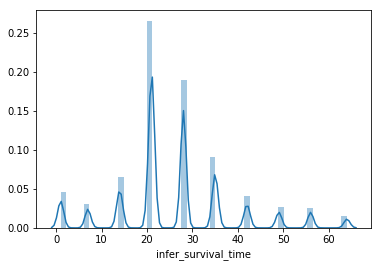

In [193]:
sns.distplot(act_oof_st['infer_survival_time'])

In [0]:
oop_st = pd.concat([act_oof_st, pay_oof_st, tra_oof_st, com_oof_st, ple_oof_st]).groupby('acc_id').min().reset_index()
oop_tas = pd.concat([act_oof_tas, pay_oof_tas, tra_oof_tas, com_oof_tas, ple_oof_tas]).groupby('acc_id').max().reset_index()

In [0]:
# metrics
from scripts.metrics.score_function import score_function

def oof_transform(st, tas):
    st_t = st.copy()
    tas_t = tas.copy()
    
#     st_t['infer_survival_time'] = st_t['infer_survival_time'].apply(lambda x: x if x==0 or x==10 else x*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: 64 if x==10 else x)
    tas_t.loc[tas['infer_total_amount_spent']<0, 'infer_total_amount_spent'] = 0
    
    oof_df = pd.merge(st_t, tas_t, how='left', on='acc_id')[['acc_id', 'infer_survival_time', 'infer_total_amount_spent']]
    oof_df.columns = ['acc_id', 'survival_time', 'amount_spent']
    oof_df['amount_spent'] = oof_df['amount_spent']/oof_df['survival_time']
    return oof_df

def pred_transform(st, tas):
    st_t = st.copy()
    tas_t = tas.copy()
    
    st_t['survival_time'] = st_t.iloc[:, 1:].min(1)
    tas_t['amount_spent'] = tas_t.iloc[:, 1:].max(1)
    
    pred_df = pd.merge(st_t, tas_t, how='left', on='acc_id')[['acc_id', 'survival_time', 'amount_spent']]
    pred_df['amount_spent'] = pred_df['amount_spent']/pred_df['survival_time']
    return pred_df

In [195]:
# 예측, 실제
score_function(oof_transform(act_oof_st, act_oof_tas),
               true_train_label)

14762.996649898378


14762.996649898378

# submission

In [0]:
pred1_st = pd.concat([act_pred_st1, pay_pred_st1, tra_pred_st1, com_pred_st1, ple_pred_st1]).groupby('acc_id').min().reset_index()
pred1_tas = pd.concat([act_pred_tas1, pay_pred_tas1, tra_pred_tas1, com_pred_tas1, ple_pred_tas1]).groupby('acc_id').max().reset_index()

pred2_st = pd.concat([act_pred_st2, pay_pred_st2, tra_pred_st2, com_pred_st2, ple_pred_st2]).groupby('acc_id').min().reset_index()
pred2_tas = pd.concat([act_pred_tas2, pay_pred_tas2, tra_pred_tas2, com_pred_tas2, ple_pred_tas2]).groupby('acc_id').max().reset_index()

In [0]:
pred_transform(pred1_st, pred1_tas).to_csv('/content/test1_predict.csv', index=False)
pred_transform(pred2_st, pred2_tas).to_csv('/content/test2_predict.csv', index=False)